In [53]:
# 数据获取示例（以茅台为例）
import tushare as ts
from datetime import datetime, timedelta

# 设置Tushare token（需注册获取）
ts.set_token('a8731f1a40780056284f98b38f64a752dd54634af0f9de53455aa897')
pro = ts.pro_api()

# 获取日线数据
df = pro.query('daily', ts_code='600519.SH', start_date='20200101', end_date='20231232')
print(df.head())

# 数据保存到CSV
df.to_csv('maotai_stock.csv')

     ts_code trade_date     open     high      low    close  pre_close  \
0  600519.SH   20231229  1720.00  1749.58  1720.00  1726.00    1724.99   
1  600519.SH   20231228  1670.99  1727.99  1667.06  1724.99    1667.06   
2  600519.SH   20231227  1668.00  1677.15  1661.00  1667.06    1670.00   
3  600519.SH   20231226  1672.50  1674.90  1657.50  1670.00    1672.00   
4  600519.SH   20231225  1671.00  1678.60  1668.00  1672.00    1670.65   

   change  pct_chg       vol       amount  
0    1.01   0.0586  27538.68  4768857.531  
1   57.93   3.4750  38338.06  6537401.380  
2   -2.94  -0.1760  16055.50  2679221.365  
3   -2.00  -0.1196  14771.26  2457177.339  
4    1.35   0.0808  12471.06  2086014.390  


In [33]:
import pandas as pd

# 加载数据
df = pd.read_csv('maotai_stock.csv', parse_dates=['trade_date'])

# 处理缺失值
df = df.dropna()

# 计算收益率
df['return'] = df['close'].pct_change()

# 计算波动率（20日标准差）
df['volatility'] = df['close'].rolling(window=20).std()

# 创建技术指标特征
df['5日均线'] = df['close'].rolling(window=5).mean()
df['10日均线'] = df['close'].rolling(window=10).mean()

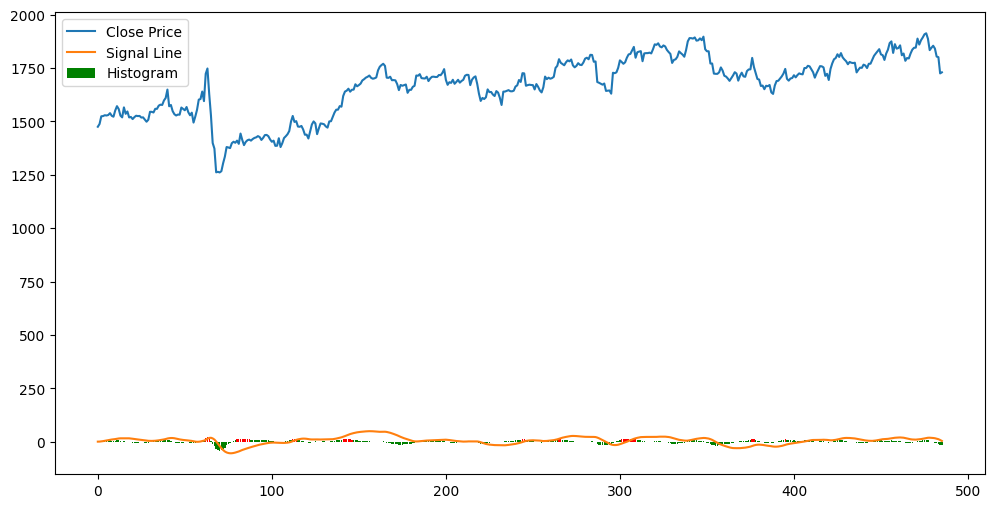

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# MACD计算示例
def calculate_macd(close, fast=12, slow=26, signal=9):
    ema_fast = close.ewm(span=fast, adjust=False).mean()
    ema_slow = close.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

# 绘制MACD柱状图
macd, signal, hist = calculate_macd(df['close'])
plt.figure(figsize=(12,6))
plt.plot(df['close'], label='Close Price')
plt.plot(signal, label='Signal Line')
plt.bar(df.index, hist, label='Histogram', color=np.where(hist > 10, 'r', 'g'))
plt.legend()
plt.show()

In [58]:
# 双均线策略实现
import pandas as pd

def double_ma_strategy(data):
    # 数据完整性检查
    if len(data) < 1:
        raise ValueError("数据集为空，请检查数据文件路径")
    
    required_columns = ['trade_date', 'close']
    missing_cols = [col for col in required_columns if col not in data]
    if missing_cols:
        raise ValueError(f"缺少必要列：{missing_cols}")
    
    # 强制转换日期格式
    data['trade_date'] = pd.to_datetime(
        data['trade_date'], 
        errors='coerce',  # 将错误转换为NaT
        format='%Y-%m-%d'
    )
    
    # 删除无效日期
    data = data.dropna(subset=['trade_date'])
    if len(data) < 1:
        raise ValueError("所有日期都无效，请检查CSV文件日期格式")
    
    # 计算均线
    data['5ma'] = data['close'].rolling(5).mean()
    data['10ma'] = data['close'].rolling(10).mean()
    
    # 生成交易信号列表（滞后1天）
    signals = [0.0] * len(data)
    for i in range(1, len(data)):
        if data['5ma'][i] > data['10ma'][i]:
            signals[i] = 1.0  # 金叉次日买入
        elif data['5ma'][i] < data['10ma'][i]:
            signals[i] = -1.0 # 死叉次日卖出
    
    # 初始化状态变量
    cash = 10000.0
    position = 0  # 持仓股数
    
    # 回测主循环
    for i in range(1, len(data)):
        prev_signal = signals[i-1]
        current_price = data['close'][i]
        
        if prev_signal == 1.0 and position == 0:
            # 执行买入
            shares = int(cash // current_price)
            cash -= shares * current_price
            position += shares
            
        elif prev_signal == -1.0 and position > 0:
            # 执行卖出
            cash += position * current_price
            position = 0
            
        # 打印调试信息（可选）
        print(f"Date: {data['trade_date'][i]}, "
              f"Signal: {prev_signal}, Price: {current_price:.2f}, "
              f"Cash: {cash:.2f}, Position: {position}")
    
    # 计算最终收益（安全访问最后价格）
    if len(data) == 0:
        final_total = cash
    else:
        final_price = data['close'].iloc[-1]
        final_total = cash + position * final_price
    
    return final_total-10000

# 示例数据加载（替换为你自己的CSV路径）
df = pd.read_csv('maotai_stock.csv', parse_dates=['trade_date'])
try:
    final_return = double_ma_strategy(df)
    print(f"双均线策略最终收益：{final_return:.2f},收益率:{final_return/10000:.2%}")
except Exception as e:
    print(f"发生错误：{str(e)}")
    print("请检查：1. CSV文件路径 2. 数据列完整性 3. 日期格式是否正确")

Date: 2023-12-28 00:00:00, Signal: 0.0, Price: 1724.99, Cash: 10000.00, Position: 0
Date: 2023-12-27 00:00:00, Signal: 0.0, Price: 1667.06, Cash: 10000.00, Position: 0
Date: 2023-12-26 00:00:00, Signal: 0.0, Price: 1670.00, Cash: 10000.00, Position: 0
Date: 2023-12-25 00:00:00, Signal: 0.0, Price: 1672.00, Cash: 10000.00, Position: 0
Date: 2023-12-22 00:00:00, Signal: 0.0, Price: 1670.65, Cash: 10000.00, Position: 0
Date: 2023-12-21 00:00:00, Signal: 0.0, Price: 1670.00, Cash: 10000.00, Position: 0
Date: 2023-12-20 00:00:00, Signal: 0.0, Price: 1649.79, Cash: 10000.00, Position: 0
Date: 2023-12-19 00:00:00, Signal: 0.0, Price: 1675.00, Cash: 10000.00, Position: 0
Date: 2023-12-18 00:00:00, Signal: 0.0, Price: 1662.00, Cash: 10000.00, Position: 0
Date: 2023-12-15 00:00:00, Signal: -1.0, Price: 1645.00, Cash: 10000.00, Position: 0
Date: 2023-12-14 00:00:00, Signal: -1.0, Price: 1635.90, Cash: 10000.00, Position: 0
Date: 2023-12-13 00:00:00, Signal: -1.0, Price: 1660.00, Cash: 10000.00, P